## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Colab Notebooks (1)/Dataset/Apel Busuk/apple_disease_classification/Augmentation"))

['Normal Apple', 'Scab Apple', 'Blotch Apple', 'Rot Apple']


In [ ]:
import numpy as np
import pandas as pd
import cv2
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [ ]:
#Read dataset
dataset = []
labels = [] 
for folder in glob.glob("/content/drive/MyDrive/Colab Notebooks (1)/Dataset/Apel Busuk/apple_disease_classification/Augmentation/*"):
    fruit_label = folder.split("/")[-1]
    for image_path in glob.glob(os.path.join(folder, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        dataset.append(image)
        labels.append(fruit_label)
fruit_images = np.array(dataset)
labels = np.array(labels)
fruit_images.shape

(4286, 128, 128, 3)

In [ ]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [ ]:
id_to_label_dict

{0: 'Blotch Apple', 1: 'Normal Apple', 2: 'Rot Apple', 3: 'Scab Apple'}

In [ ]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [ ]:
def plot_image_grid(images, rows, columns):
    figure = plt.figure(figsize=(columns * 2, rows * 2))
    for i in range(columns * rows):
        figure.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i])
    plt.show()

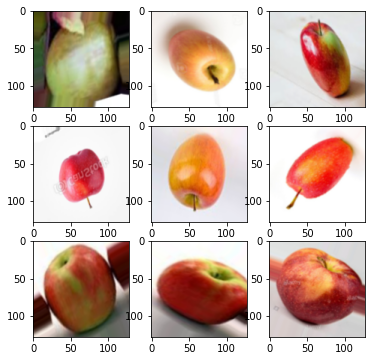

In [ ]:
plot_image_grid(dataset[0:100], 3, 3)

In [ ]:
scaler = StandardScaler()

In [ ]:
images_scaled = scaler.fit_transform([i.flatten() for i in dataset])

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images_scaled, label_ids, test_size=0.2, random_state=42)

In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
n_components_array = [10, 20, 30, 40, 50]

model = SVC(random_state=0)

for n_components in n_components_array:

    pca = PCA(n_components=n_components)
    pca = pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    model.fit(X_train_pca, y_train)
    test_predictions = model.predict(X_test_pca)

    print("n_components = ", n_components)
    print("------------------")
    print("confusion matrix")
    print(confusion_matrix(y_test, test_predictions))
    print('\n')
    print("classification report")
    print(classification_report(y_test, test_predictions))

    print("Training set score for SVM: %f" % model.score(X_train_pca , y_train))
    print("Testing  set score for SVM: %f" % model.score(X_test_pca  , y_test ))
    print('\n')
    print("------------------------------------------------------------------------------------------")

n_components =  10
------------------
confusion matrix
[[161   6   8  38]
 [  6 177  37  12]
 [ 10  13 149  24]
 [ 11  10  10 186]]


classification report
              precision    recall  f1-score   support

           0       0.86      0.76      0.80       213
           1       0.86      0.76      0.81       232
           2       0.73      0.76      0.74       196
           3       0.72      0.86      0.78       217

    accuracy                           0.78       858
   macro avg       0.79      0.78      0.78       858
weighted avg       0.79      0.78      0.79       858

Training set score for SVM: 0.831097
Testing  set score for SVM: 0.784382


------------------------------------------------------------------------------------------
n_components =  20
------------------
confusion matrix
[[187   5   4  17]
 [  3 193  29   7]
 [ 10   3 161  22]
 [ 12   8  10 187]]


classification report
              precision    recall  f1-score   support

           0       0.88      0.

## Firefly Algorithm

In [ ]:
!pip3 install tqdm ipywidgets widgetsnbextension pandas-profiling
import numpy as np
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.svm import LinearSVC

class FireflyAlgorithm:
    def __init__(self, pop_size=20, alpha=1.0, betamin=1.0, gamma=0.01, seed=None):
        self.pop_size = pop_size
        self.alpha = alpha
        self.betamin = betamin
        self.gamma = gamma
        self.rng = default_rng(seed)

    def run(self, function, dim, lb, ub, max_evals):
        fireflies = self.rng.uniform(lb, ub, (self.pop_size, dim))
        intensity = np.apply_along_axis(function, 1, fireflies)
        best = np.min(intensity)
        best_frfly = fireflies[0]

        evaluations = self.pop_size
        new_alpha = self.alpha
        search_range = ub - lb

        while evaluations <= max_evals:
            new_alpha *= 0.97
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if intensity[i] >= intensity[j]:
                        r = np.sum(np.square(fireflies[i] - fireflies[j]), axis=-1)
                        beta = self.betamin * np.exp(-self.gamma * r)
                        steps = new_alpha * (self.rng.random(dim) - 0.5) * search_range
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + steps
                        fireflies[i] = np.clip(fireflies[i], lb, ub)
                        intensity[i] = function(fireflies[i])
                        evaluations += 1
                        best = min(intensity[i], best)
                        if best == intensity[i] :
                            best_frfly = fireflies[i].copy()
        return best, best_frfly, fireflies
    
    def run_svm_fit(self, svm_model, X, Y, parameters, max_evals, kernel='rbf', random_state=None) :
        np.random.seed(random_state)
        if kernel=='linear' :
            svm_model = LinearSVC
        fireflies_c = np.random.uniform(parameters['c_min'], parameters['c_max'], self.pop_size)
        fireflies_gamma = np.random.uniform(parameters['gamma_min'], parameters['gamma_max'], self.pop_size)

        x_train, x_test, y_train, y_test = train_test_split(X, Y)
        
        intensity = []
        print("Training numbers of SVM models ...")
        
        print("Generating intensity (Trains SVM Model)")
        for i in tqdm(range(self.pop_size)) :
            if kernel=='linear' :
                intensity.append(svm_model(C=fireflies_c[i], random_state=random_state))
            else:
                intensity.append(svm_model(C=fireflies_c[i], kernel=kernel, gamma=fireflies_gamma[i], random_state=random_state))
            intensity[i].fit(x_train, y_train)
        best_score = []

        for y in range(len(intensity)) :
            best_score.append(intensity[y].score(x_test, y_test))
        best = intensity[best_score.index(max(best_score))]
        best_curr_score = best_score[best_score.index(max(best_score))]
        print("Current best score :", best_curr_score)
        
        evaluations = self.pop_size
        new_alpha = self.alpha
        search_c = parameters['c_max'] - parameters['c_min']
        search_gamma = parameters['gamma_max'] - parameters['gamma_min']
        
        print("Searching..")
        while evaluations <= max_evals :
            new_alpha *= 0.97
            for i in tqdm(range(self.pop_size)) :
                for j in range(self.pop_size) :
                    if best_score[i] <= best_score [j] :
                        r_c = np.square(fireflies_c[i] - fireflies_c[j])
                        beta_c = self.betamin * np.exp(-self.gamma * r_c)
                        steps_c = new_alpha * (np.random.random() - 0.5) * search_c
                        
                        fireflies_c[i] += beta_c * (fireflies_c[j] - fireflies_c[i]) + steps_c
                        fireflies_c[i] = np.clip(fireflies_c[i], parameters['c_min'], parameters['c_max'])
                        
                        r_gamma = np.square(fireflies_c[i] - fireflies_gamma[j])
                        beta_gamma = self.betamin * np.exp(-self.gamma * r_gamma)
                        steps_gamma = new_alpha * (np.random.random() - 0.5) * search_gamma
                        
                        fireflies_gamma[i] += beta_gamma * (fireflies_gamma[j] - fireflies_gamma[i]) + steps_gamma
                        fireflies_gamma[i] = np.clip(fireflies_gamma[i], parameters['gamma_min'], parameters['gamma_max'])
                        
                        if kernel=='linear' :
                            intensity[i] = svm_model(C = fireflies_c[i], random_state=random_state)
                        else:
                            intensity[i] = svm_model(C = fireflies_c[i], kernel=kernel, gamma=fireflies_gamma[i], random_state=random_state)
                        intensity[i].fit(x_train,y_train)
                        
                        evaluations += 1
                        
                        this_score = intensity[i].score(x_test,y_test)
                        best_curr_score = max(this_score, best_curr_score)
                        if best_curr_score == this_score :
                            best = intensity[i]
        print("Best model : ", best)
        print("Score (Accuracy) : ", best_curr_score)
        return best

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 33.2 MB/s 


In [ ]:
%%time
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

FA = FireflyAlgorithm()

for n_components in n_components_array:

    pca = PCA(n_components=n_components)
    pca = pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("n_components = ", n_components)
    print("------------------")

    params = {'c_min':1, 'c_max':100, 'gamma_min':0.0001, 'gamma_max':1}

    FA = FireflyAlgorithm(pop_size=30, seed=42)
    fa_model = FA.run_svm_fit(SVC, X_train_pca, y_train, params, max_evals=1000)
    Y_pred = fa_model.predict(X_test_pca)

    print('\nBest C:',fa_model.C,"")
    print('Best Gamma:',fa_model.gamma,"\n")

    print("confusion matrix")
    print(confusion_matrix(y_test, Y_pred))
    print('\n')
    print("classification report")
    print(classification_report(y_test, Y_pred))

    print("Training set score for FA-SVM: %f" % fa_model.score(X_train_pca , y_train))
    print("Testing  set score for FA-SVM: %f" % fa_model.score(X_test_pca  , y_test ))
    print('\n')
    print("------------------------------------------------------------------------------------------")

n_components =  10
------------------
Training numbers of SVM models ...
Generating intensity (Trains SVM Model)


100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


Current best score : 0.26254375729288215
Searching..


100%|██████████| 30/30 [05:15<00:00, 10.51s/it]


Best model :  SVC(C=21.901195020056623, gamma=0.0001)
Score (Accuracy) :  0.9369894982497082

Best C: 21.901195020056623 
Best Gamma: 0.0001 

confusion matrix
[[201   4   4   4]
 [  1 221   6   4]
 [  9  10 170   7]
 [  6   5   1 205]]


classification report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       213
           1       0.92      0.95      0.94       232
           2       0.94      0.87      0.90       196
           3       0.93      0.94      0.94       217

    accuracy                           0.93       858
   macro avg       0.93      0.93      0.93       858
weighted avg       0.93      0.93      0.93       858

Training set score for FA-SVM: 0.983664
Testing  set score for FA-SVM: 0.928904


------------------------------------------------------------------------------------------
n_components =  20
------------------
Training numbers of SVM models ...
Generating intensity (Trains SVM Model)


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


Current best score : 0.6196032672112018
Searching..


100%|██████████| 30/30 [06:49<00:00, 13.65s/it]


Best model :  SVC(C=2.7370128855851914, gamma=0.0001)
Score (Accuracy) :  0.9626604434072346

Best C: 2.7370128855851914 
Best Gamma: 0.0001 

confusion matrix
[[206   0   3   4]
 [  2 217   8   5]
 [  3   4 182   7]
 [  3   6   1 207]]


classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       213
           1       0.96      0.94      0.95       232
           2       0.94      0.93      0.93       196
           3       0.93      0.95      0.94       217

    accuracy                           0.95       858
   macro avg       0.95      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858

Training set score for FA-SVM: 0.989790
Testing  set score for FA-SVM: 0.946387


------------------------------------------------------------------------------------------
n_components =  30
------------------
Training numbers of SVM models ...
Generating intensity (Trains SVM Model)


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


Current best score : 0.27537922987164526
Searching..


100%|██████████| 30/30 [10:57<00:00, 21.92s/it]


Best model :  SVC(C=96.92215051615419, gamma=0.0001)
Score (Accuracy) :  0.9533255542590432

Best C: 96.92215051615419 
Best Gamma: 0.0001 

confusion matrix
[[208   0   2   3]
 [  1 223   4   4]
 [  4   3 183   6]
 [  4   5   1 207]]


classification report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       213
           1       0.97      0.96      0.96       232
           2       0.96      0.93      0.95       196
           3       0.94      0.95      0.95       217

    accuracy                           0.96       858
   macro avg       0.96      0.96      0.96       858
weighted avg       0.96      0.96      0.96       858

Training set score for FA-SVM: 0.988331
Testing  set score for FA-SVM: 0.956876


------------------------------------------------------------------------------------------
n_components =  40
------------------
Training numbers of SVM models ...
Generating intensity (Trains SVM Model)


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Current best score : 0.2310385064177363
Searching..


100%|██████████| 30/30 [12:27<00:00, 24.91s/it]


Best model :  SVC(C=96.73443996455406, gamma=0.0001)
Score (Accuracy) :  0.941656942823804

Best C: 96.73443996455406 
Best Gamma: 0.0001 

confusion matrix
[[207   0   4   2]
 [  3 226   2   1]
 [  4   7 179   6]
 [  5   5   1 206]]


classification report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       213
           1       0.95      0.97      0.96       232
           2       0.96      0.91      0.94       196
           3       0.96      0.95      0.95       217

    accuracy                           0.95       858
   macro avg       0.95      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858

Training set score for FA-SVM: 0.985414
Testing  set score for FA-SVM: 0.953380


------------------------------------------------------------------------------------------
n_components =  50
------------------
Training numbers of SVM models ...
Generating intensity (Trains SVM Model)


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Current best score : 0.2555425904317386
Searching..


100%|██████████| 30/30 [13:45<00:00, 27.53s/it]


Best model :  SVC(C=100.0, gamma=0.0001)
Score (Accuracy) :  0.9521586931155193

Best C: 100.0 
Best Gamma: 0.0001 

confusion matrix
[[207   0   1   5]
 [  1 228   2   1]
 [  4   4 179   9]
 [  3   6   3 205]]


classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       213
           1       0.96      0.98      0.97       232
           2       0.97      0.91      0.94       196
           3       0.93      0.94      0.94       217

    accuracy                           0.95       858
   macro avg       0.96      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858

Training set score for FA-SVM: 0.988040
Testing  set score for FA-SVM: 0.954545


------------------------------------------------------------------------------------------
CPU times: user 1h 43min 21s, sys: 11.3 s, total: 1h 43min 33s
Wall time: 1h 42min 10s
